< 9. [Fouille de données](09-fouille-donnees.ipynb) | [Contents](index.ipynb) |

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
#import mplleaflet

In [2]:
accidents = gpd.read_file("donnees/accidents-geobase/accidents_2018.shp")
accidents = accidents[~accidents.geometry.isnull()]
accidents.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 21381 entries, 0 to 21384
Data columns (total 71 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POLY_ID     21381 non-null  float64 
 1   NO_SEQ_COL  21381 non-null  object  
 2   JR_SEMN_AC  21381 non-null  object  
 3   DT_ACCDN    21381 non-null  object  
 4   CD_MUNCP    21377 non-null  float64 
 5   NO_CIVIQ_A  8868 non-null   float64 
 6   SFX_NO_CIV  49 non-null     object  
 7   BORNE_KM_A  7 non-null      float64 
 8   RUE_ACCDN   20257 non-null  object  
 9   TP_REPRR_A  13625 non-null  float64 
 10  ACCDN_PRES  14465 non-null  object  
 11  NB_METRE_D  4394 non-null   float64 
 12  CD_GENRE_A  20662 non-null  float64 
 13  CD_SIT_PRT  474 non-null    float64 
 14  CD_ETAT_SU  20519 non-null  float64 
 15  CD_ECLRM    20572 non-null  float64 
 16  CD_ENVRN_A  20829 non-null  float64 
 17  NO_ROUTE    77 non-null     float64 
 18  CD_CATEG_R  20930 non-null  float64 
 

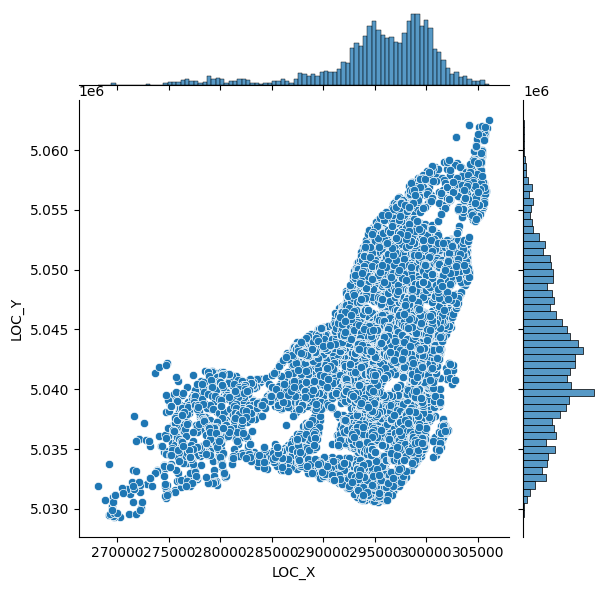

In [3]:
sns.jointplot(x="LOC_X", y="LOC_Y", data=accidents)

# Mesures de centralité

In [4]:
from pointpats import PointPattern
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance, euclidean_median#,ellipse # problem
pp = PointPattern(accidents[['LOC_X','LOC_Y']])
pp.summary()
pp10 = PointPattern(pp.points[::10])

Point Pattern
21381 points
Bounding rectangle [(268161.55812,5029325.1705), (306077.46146,5062512.1035)]
Area of window: 1258312543.7790642
Intensity estimate for window: 1.6991803908897612e-05
              x             y
0  277363.60800  5.034994e+06
1  274551.05174  5.033633e+06
2  277946.00000  5.035171e+06
3  276486.60700  5.038090e+06
4  279219.92101  5.040510e+06


In [5]:
pp10.points.to_numpy()

array([[ 277363.608  , 5034993.988  ],
       [ 279672.932  , 5040719.47   ],
       [ 277431.517  , 5038842.1    ],
       ...,
       [ 276982.781  , 5034955.     ],
       [ 277307.23299, 5036401.518  ],
       [ 277036.85838, 5034367.4494 ]])

[ 295248.31891199 5042923.71750606]


(266265.762953, 307973.256627, 5027665.82385, 5064171.45015)

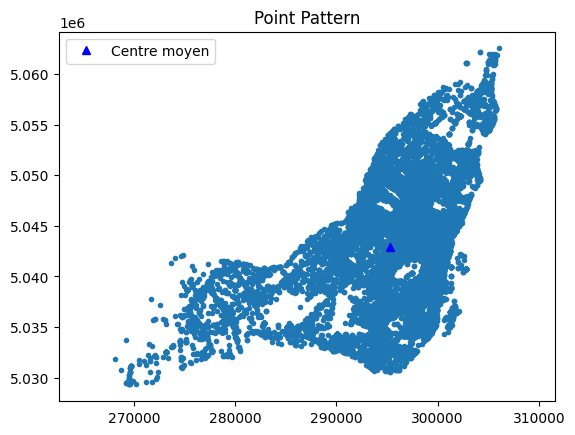

In [6]:
mc = mean_center(pp.points)
print(mc)
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Centre moyen')
plt.legend(numpoints=1)
plt.axis('equal')

[ 295110.32998692 5043326.28947861]


(5040923.717506057, 5044923.717506057)

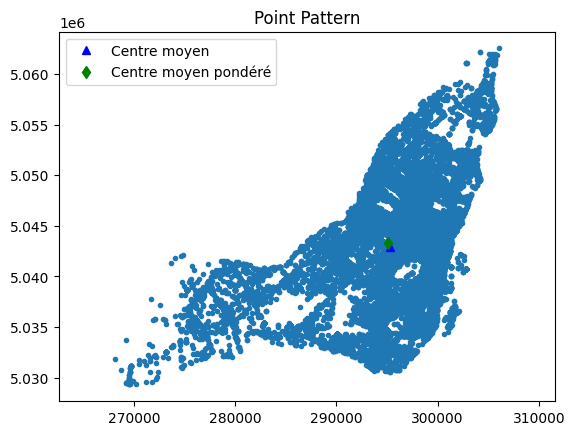

<Figure size 640x480 with 0 Axes>

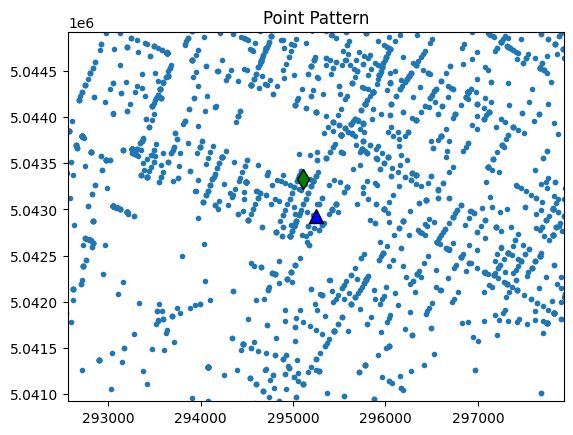

In [7]:
# centre moyen pondéré
wmc = weighted_mean_center(pp.points, accidents['NB_BLESSES']+accidents['NB_MORTS']) 
# accidents[['NB_BLESSES','NB_MORTS']].sum(axis=1)
print(wmc)
pp.plot() #use class method "plot" to visualize point pattern
plt.plot(mc[0], mc[1], 'b^', label='Centre moyen') 
plt.plot(wmc[0], wmc[1], 'gd', label='Centre moyen pondéré')
plt.legend(numpoints=1)
plt.axis('equal')
plt.figure()
pp.plot() #use class method "plot" to visualize point pattern
plt.plot(mc[0], mc[1], 'b^', label='Centre moyen', mec = 'k', ms = 10) 
plt.plot(wmc[0], wmc[1], 'gd', label='Centre moyen pondéré', mec = 'k', ms = 10)
#plt.legend(numpoints=1)
plt.axis('equal')
plt.xlim(mc[0]-2000,mc[0]+2000)
plt.ylim(mc[1]-2000,mc[1]+2000)

8475.721664485312


(267681.4735395, 307394.6514505, 5028144.21215, 5063509.12085)

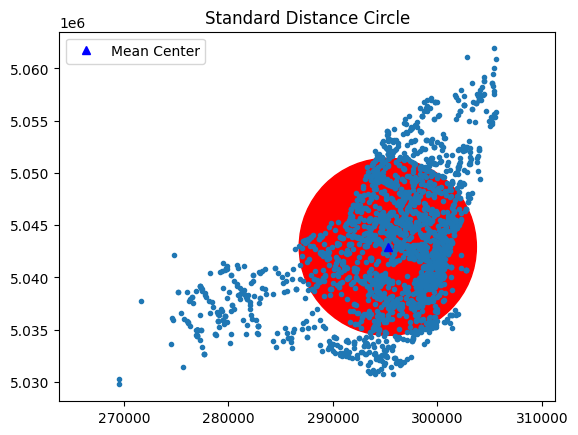

In [8]:
# Écart-type de la distance de chaque point par rapport au centre moyen
stdd = std_distance(pp.points)
print(stdd)
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r')
ax = pp10.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.set_aspect('equal')
plt.legend(numpoints=1)
plt.axis('equal')

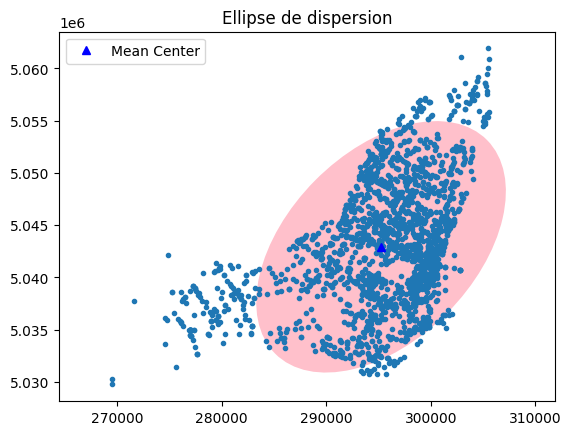

In [9]:
# Ellipse de dispersion
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
#sx, sy, theta = ellipse(pp.points) # ellipse from pointpats has issues
#fig, ax = plt.subplots(1, figsize = (10,10))
ax = pp10.plot(title='Ellipse de dispersion', get_ax = True)
e = confidence_ellipse(pp.points.x, pp.points.y, ax, 2, 'pink')#Ellipse(xy=mc, width=sx*2, height=sy*2, angle=-theta*180./np.pi) #angle is rotation in degrees (anti-clockwise)
#ax.add_artist(e)
#e.set_clip_box(ax.bbox)
#e.set_facecolor([0.8,0,0])
#e.set_edgecolor([1,0,0])
#ax.set_xlim(0,100)
#ax.set_ylim(0,100)
ax.set_aspect('equal')
plt.axis('equal')
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)

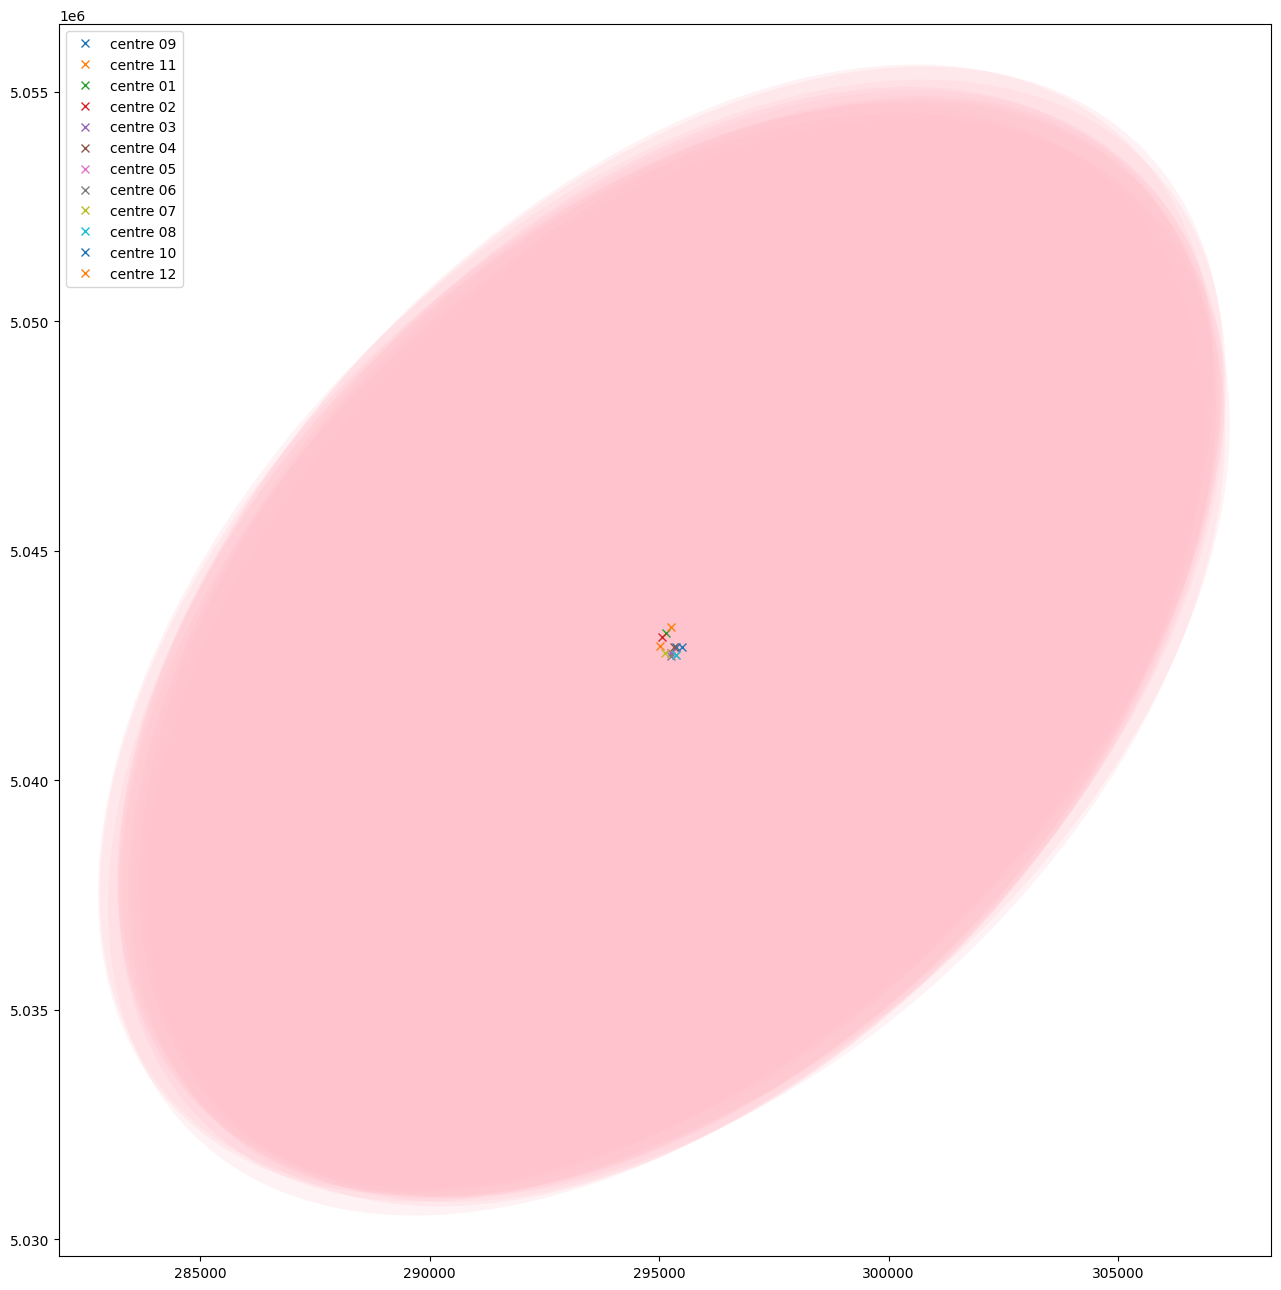

In [10]:
fig, ax = plt.subplots(1, figsize = (16,16))
for mois in accidents.MOIS.unique():
    points = accidents.loc[accidents.MOIS == mois, ['LOC_X','LOC_Y']]
    #sx, sy, theta = ellipse(points)
    #print(sx, sy, theta)
    c = mean_center(points)
    confidence_ellipse(points['LOC_X'], points['LOC_Y'], ax, 2, 'pink', alpha=0.2)
    plt.plot(c[0], c[1], 'x',label='centre '+mois)
ax.set_aspect('equal')
#plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend()

[[ 268161.55812 5031884.5624 ]
 [ 269196.26049 5029489.2959 ]
 [ 269542.71901 5029358.     ]
 [ 269642.5025  5029325.1705 ]
 [ 295279.504   5030599.774  ]
 [ 295965.844   5030716.     ]
 [ 296201.77994 5030777.3172 ]
 [ 300977.36554 5034486.8432 ]
 [ 301434.531   5035172.871  ]
 [ 302078.459   5036587.127  ]
 [ 305561.436   5055567.513  ]
 [ 305739.934   5056567.26   ]
 [ 306077.46146 5062512.1035 ]
 [ 304138.456   5062121.259  ]
 [ 274023.12652 5041829.4849 ]
 [ 273689.42659 5041354.562  ]
 [ 269225.8437  5033754.4181 ]] (268161.55812, 5029325.1705, 306077.46146, 5062512.1035)


/tmp/ipykernel_1582326/4096082648.py:1: FutureWarning: This function will be deprecated in the next release of pointpats.
  print(hull(pp.points), mbr(pp.points))


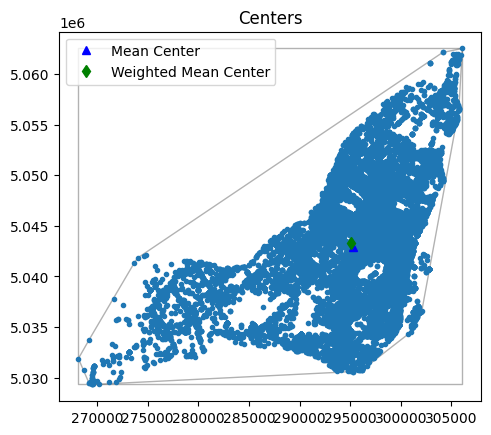

In [11]:
print(hull(pp.points), mbr(pp.points))
pp.plot(title='Centers', hull=True, window = True ) #plot point pattern "pp" as well as its convex hull
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.legend()

# Test de structure spatiale
Nous allons tester si la distribution des lieux des accidents suit une structure spatiale complètement aléatoire.

In [12]:
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
import pointpats.quadrat_statistics as qs

In [13]:
ile = ps.io.open('donnees/accidents-geobase/terre_shp.shp')
polys = [p for p in ile]
pmax=polys[0]
for p in polys:
    if p.area>pmax.area:
        pmax = p
window = Window(pmax.parts)

In [14]:
samples = PoissonPointProcess(window, 200, 1, conditioning=False, asPP=True)

Point Pattern
200 points
Bounding rectangle [(269044.57070915523,5029592.340692256), (305470.4487126559,5061913.385441775)]
Area of window: 469190279.23398113
Intensity estimate for window: 4.262662907819148e-07
               x             y
0  292201.712023  5.046983e+06
1  288450.494734  5.043731e+06
2  298208.154063  5.047250e+06
3  304121.226102  5.050319e+06
4  295540.242325  5.050035e+06


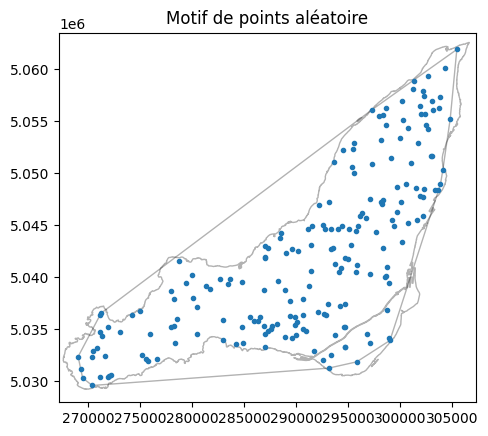

In [15]:
pp_csr = samples.realizations[0]
pp_csr.plot(window=True, hull=True, title='Motif de points aléatoire')
pp_csr.summary()
#plt.plot(*pmax.exterior.xy)

In [16]:
pp.summary()
print(pp.lambda_mbb, pp.lambda_hull)

Point Pattern
21381 points
Bounding rectangle [(268161.55812,5029325.1705), (306077.46146,5062512.1035)]
Area of window: 1258312543.7790642
Intensity estimate for window: 1.6991803908897612e-05
              x             y
0  277363.60800  5.034994e+06
1  274551.05174  5.033633e+06
2  277946.00000  5.035171e+06
3  276486.60700  5.038090e+06
4  279219.92101  5.040510e+06
1.6991803908897612e-05 3.1640330921407954e-05


78355.82241242225 199 0.0


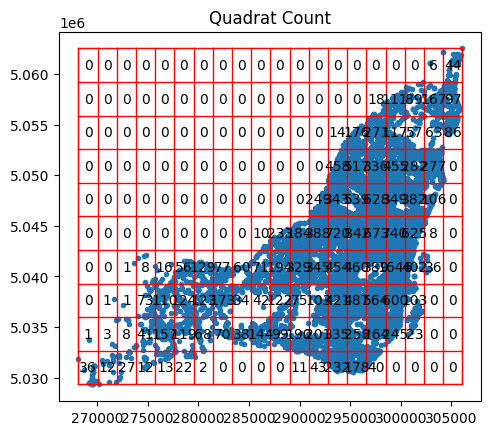

In [17]:
q_r = qs.QStatistic(pp,shape= "rectangle",nx = 20, ny = 10)
#plt.figure(figsize=(12,12))
q_r.plot()
print(q_r.chi2,q_r.df,q_r.chi2_pvalue)

218.0 49 3.509069284873771e-23


<Figure size 1200x1200 with 0 Axes>

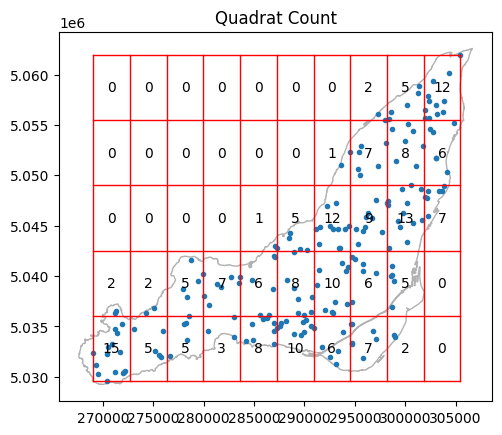

In [18]:
q_r = qs.QStatistic(pp_csr,shape= "rectangle",nx = 10, ny = 5)
plt.figure(figsize=(12,12))
q_r.plot()
print(q_r.chi2,q_r.df,q_r.chi2_pvalue)

363.48999999999995 26 3.402898282142964e-61


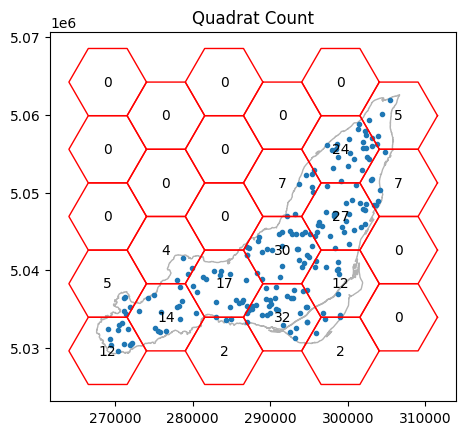

In [19]:
q_h = qs.QStatistic(pp_csr,shape= "hexagon",lh = 5000)
q_h.plot()
print(q_h.chi2,q_h.df,q_h.chi2_pvalue)

449.928 51 3.06517869960549e-65
97.3 99 0.5295121182914168


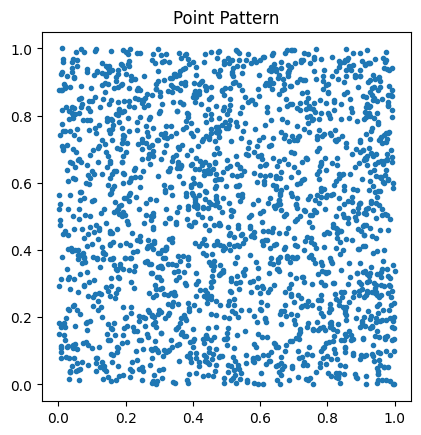

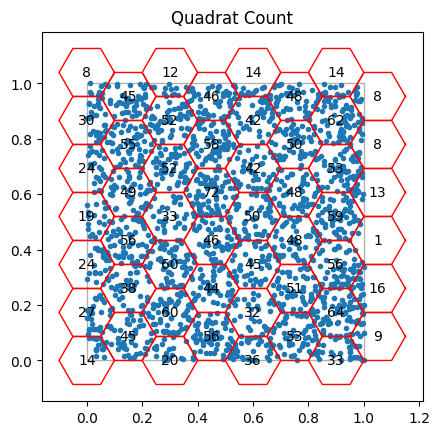

<Figure size 1200x1200 with 0 Axes>

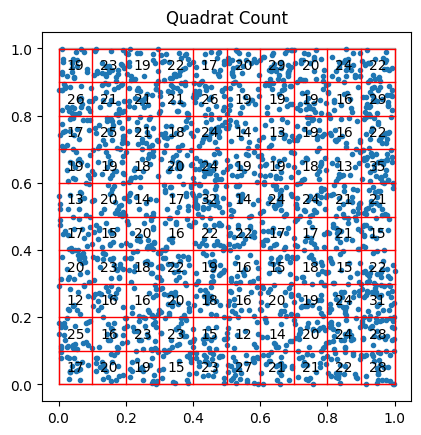

In [20]:
points = [[0., 0.], [0., 1.], [1., 1.], [1., 0.]]
samples2 = PoissonPointProcess(PointPattern(points).get_window(), 2000, 1, conditioning=False, asPP=True)
pp_csr2 = samples2.realizations[0]
pp_csr2.plot()
q_h = qs.QStatistic(pp_csr2,shape= "hexagon",lh = 0.1)
q_h.plot()
print(q_h.chi2,q_h.df,q_h.chi2_pvalue)
q_r = qs.QStatistic(pp_csr2,shape= "rectangle",nx = 10, ny = 10)
plt.figure(figsize=(12,12))
q_r.plot()
print(q_r.chi2,q_r.df,q_r.chi2_pvalue)

<Axes: xlabel='x', ylabel='y'>

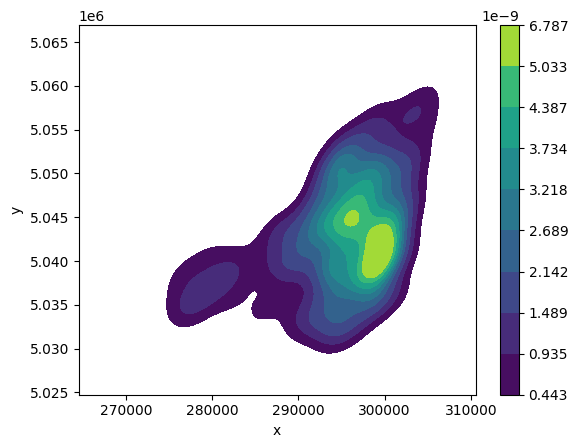

In [23]:
# kernel density estimation
sns.kdeplot(data=pp10.points, x='x', y='y', fill=True, cmap='viridis', cbar = True)
#pp.plot()

<Axes: >

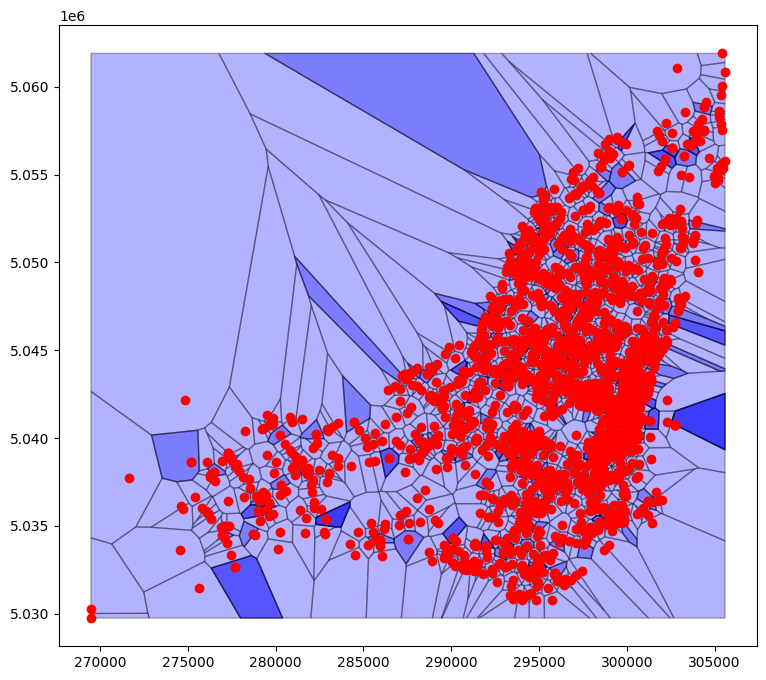

In [24]:
# diagramme de Voronoi
from libpysal.cg.voronoi  import voronoi, voronoi_frames, as_dataframes
regions, vertices = voronoi(pp10.points)
#vertices.shape
#plt.plot(vertices[:,0],vertices[:,1])
region_df, point_df = voronoi_frames(np.asarray(pp10.points))
#as_dataframes(regions, vertices, pp10.points)
#points = [(10.2, 5.1), (4.7, 2.2), (5.3, 5.7), (2.7, 5.3)]
#region_df, point_df = voronoi_frames(points)
fig, ax = plt.subplots(1,figsize=(9,9))
region_df.plot(ax=ax, color='blue',edgecolor='black', alpha=0.3)
point_df.plot(ax=ax, color='red')

(5035000.0, 5046000.0)

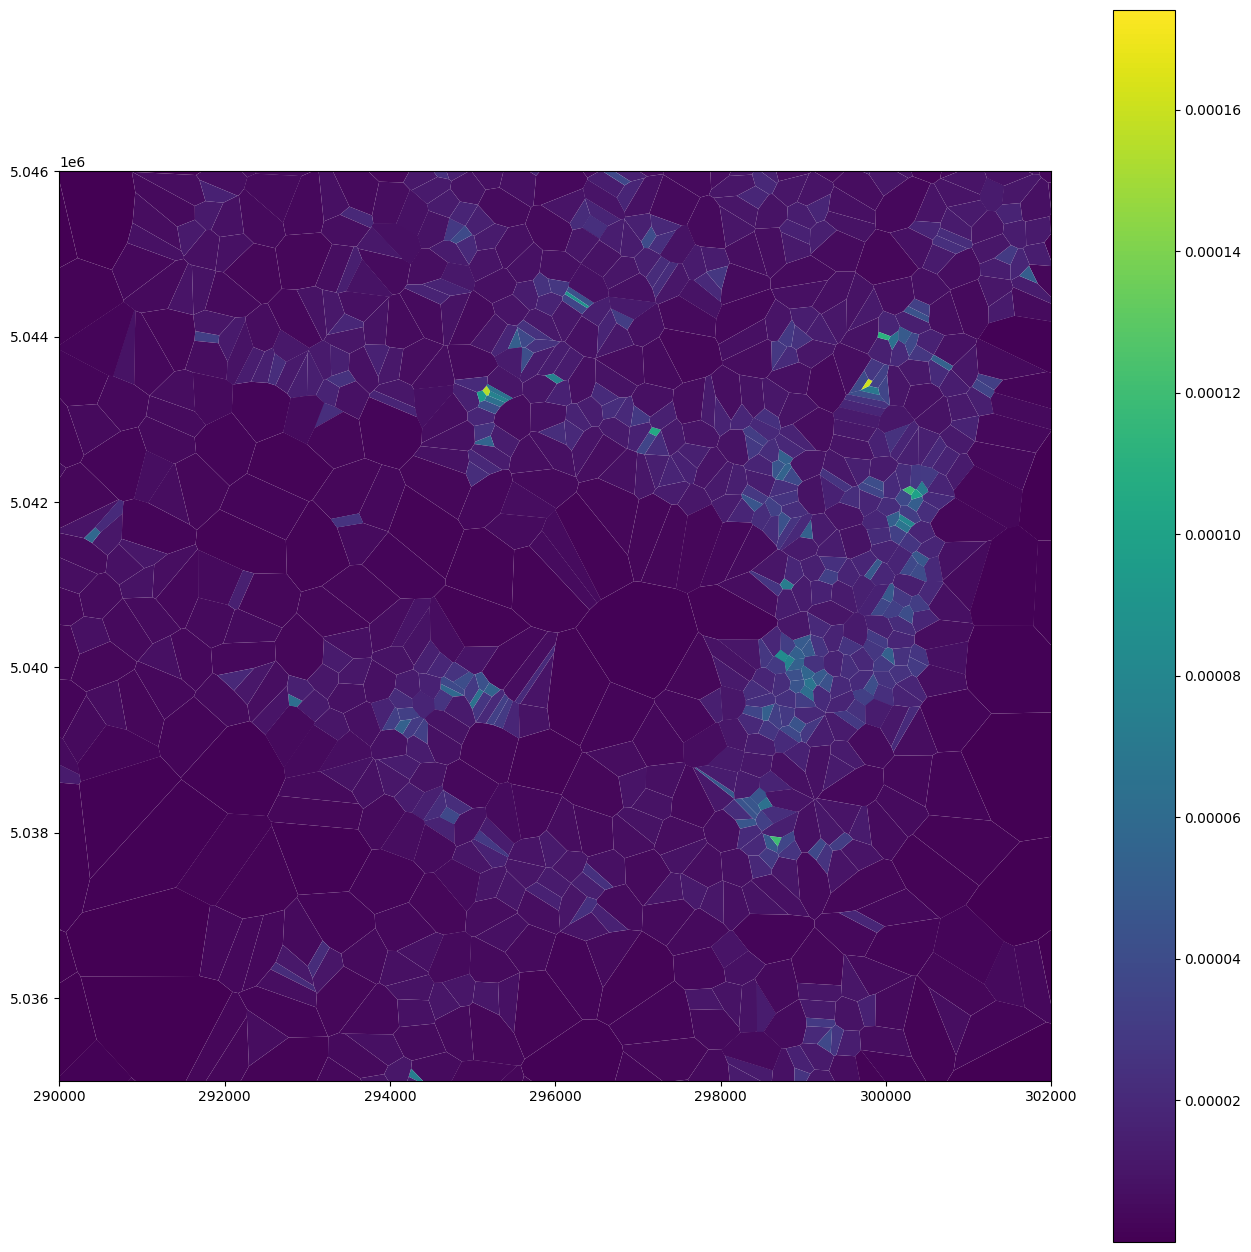

In [25]:
region_df['aires'] = 1/region_df.area
f, ax = plt.subplots(1, figsize=(16, 16))
region_df.plot(column='aires', legend = True, ax=ax)
#accidents[::10].plot(ax=ax)
#xmin, xmax = plt.xlim()
#ymin, ymax = plt.ylim()
plt.xlim(290000, 302000)
plt.ylim(5035000, 5046000)

# Auto-corrélation spatiale

In [26]:
from libpysal.weights import Queen, Rook, KNN

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   RA          41 non-null     float64 
 1   SM13        41 non-null     float64 
 2   SM13_nom    41 non-null     object  
 3   NACCIDENTS  41 non-null     float64 
 4   geometry    41 non-null     geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 1.7+ KB


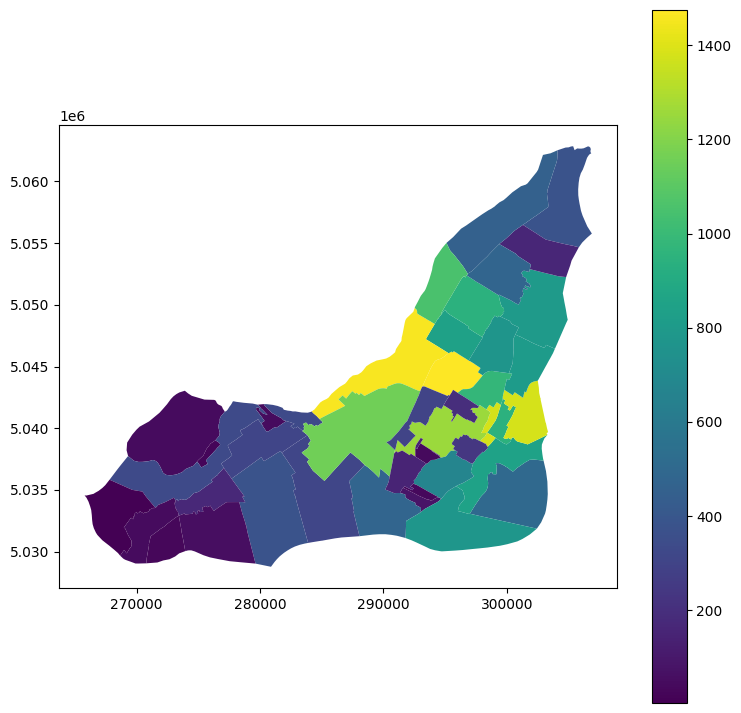

In [27]:
data = gpd.read_file('donnees/accidents-geobase/accidents_2018_smod13.shp')
f, ax = plt.subplots(1, figsize=(9, 9))
data.plot(column='NACCIDENTS', legend = True, ax=ax)
data.info()

<Axes: >

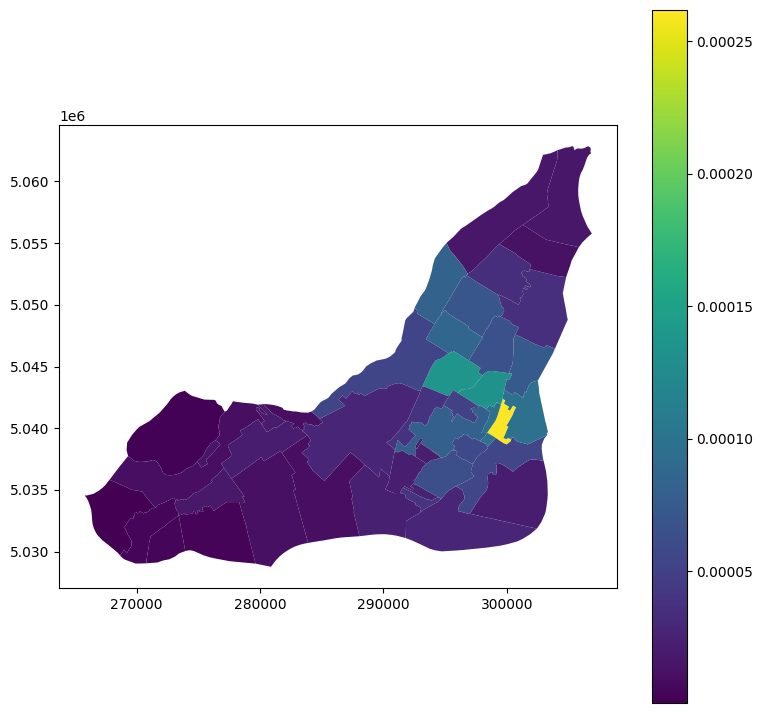

In [28]:
data['DENSITE_ACCIDENTS'] = data['NACCIDENTS']/data.geometry.area
f, ax = plt.subplots(1, figsize=(9, 9))
data.plot(column='DENSITE_ACCIDENTS', legend = True, ax=ax)

/tmp/ipykernel_1582326/1117239416.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = Rook.from_dataframe(data)


[(1, 1), (2, 8), (3, 3), (4, 9), (5, 9), (6, 9), (7, 0), (8, 1), (9, 1)]

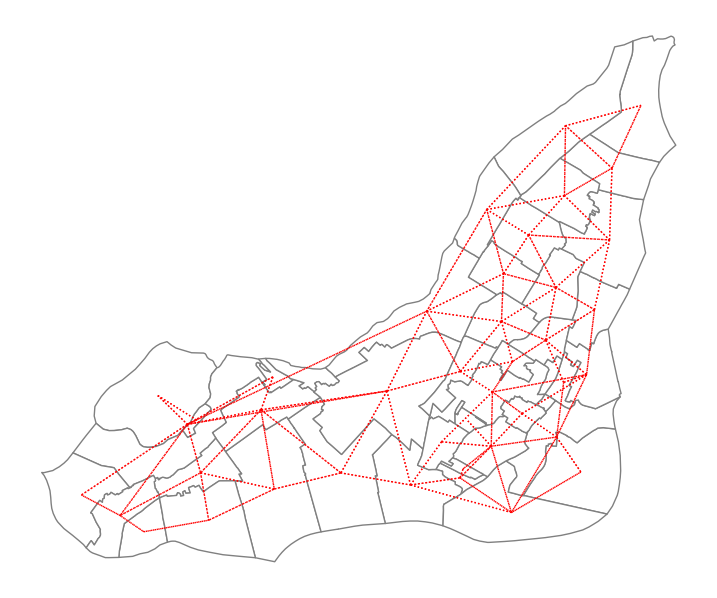

In [29]:
w_rook = Rook.from_dataframe(data)
ax = data.plot(edgecolor='grey', facecolor='w', figsize = (9,9))
f,ax = w_rook.plot(data, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
w_rook.histogram

/tmp/ipykernel_1582326/1795645361.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = Queen.from_dataframe(data)


[(2, 6), (3, 4), (4, 8), (5, 10), (6, 7), (7, 3), (8, 2), (9, 1)]

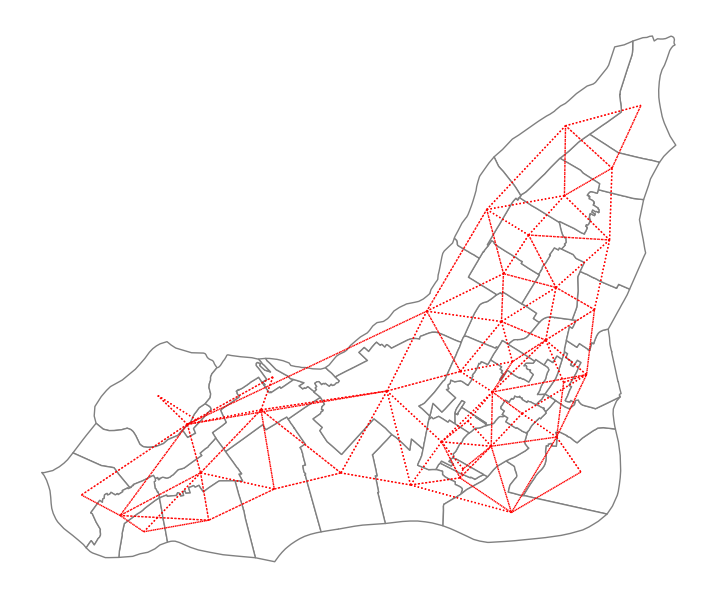

In [30]:
w_queen = Queen.from_dataframe(data)
ax = data.plot(edgecolor='grey', facecolor='w', figsize = (9,9))
f,ax = w_queen.plot(data, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
w_queen.histogram

[(4, 41)]

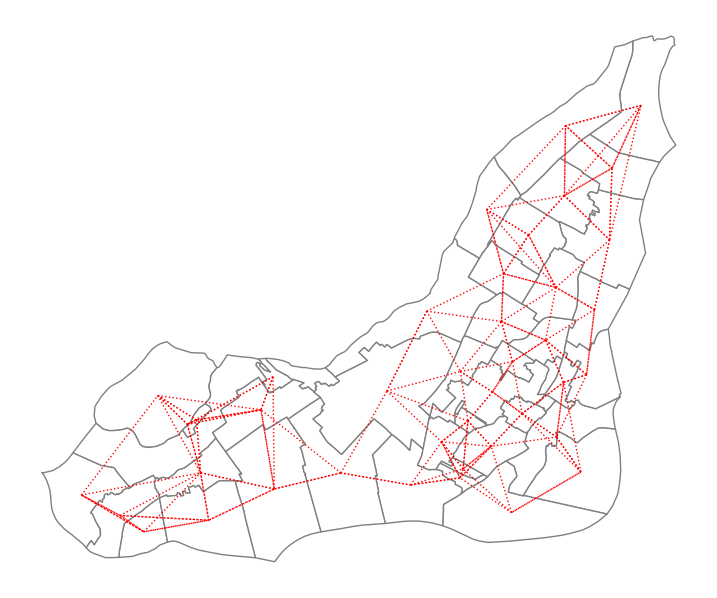

In [31]:
w_knn = KNN.from_dataframe(data, k=4)
ax = data.plot(edgecolor='grey', facecolor='w', figsize = (9,9))
f,ax = w_knn.plot(data, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
w_knn.histogram
# from libpysal.weights.contiguity import Voronoi as Vornoi_weights
# w = Vornoi_weights(points)

<Axes: >

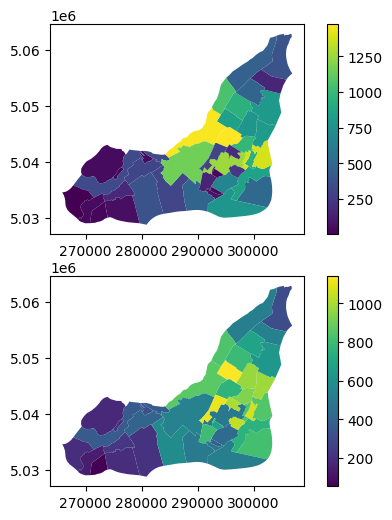

In [32]:
w_rook.transform = 'r'
data['NACCIDENTS_LAG'] = ps.weights.lag_spatial(w_rook, data.NACCIDENTS)
f, (ax1,ax2) = plt.subplots(2, figsize=(6,6))
data.plot(column='NACCIDENTS', legend = True, ax=ax1)
data.plot(column='NACCIDENTS_LAG', legend = True, ax=ax2)

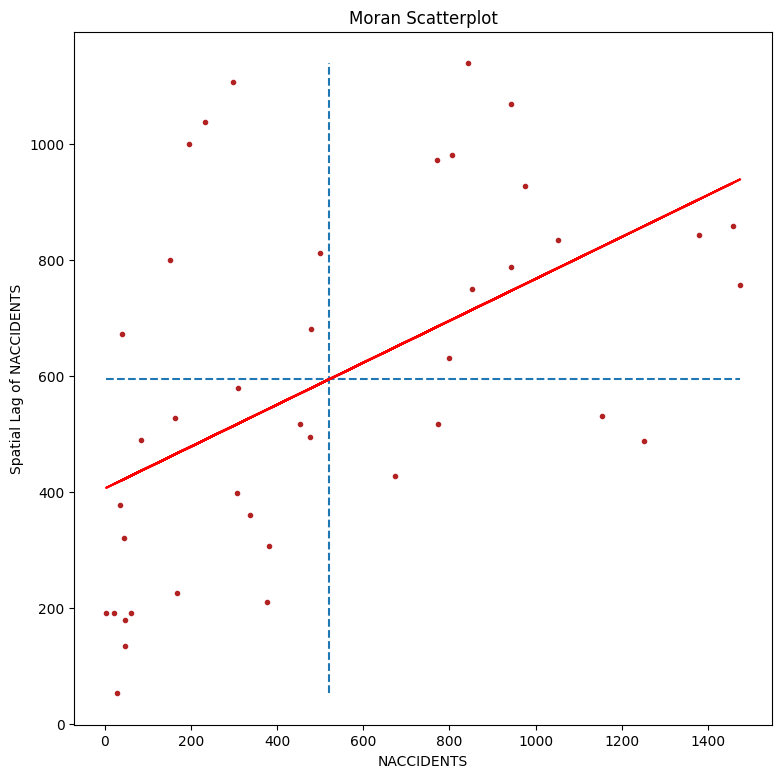

In [33]:
# moran plot
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(data.NACCIDENTS, data.NACCIDENTS_LAG, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(data.NACCIDENTS.mean(), data.NACCIDENTS_LAG.min(), data.NACCIDENTS_LAG.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(data.NACCIDENTS_LAG.mean(), data.NACCIDENTS.min(), data.NACCIDENTS.max(), linestyle='--')

# red line of best fit using global I as slope
b,a = np.polyfit(data.NACCIDENTS, data.NACCIDENTS_LAG, 1)
plt.plot(data.NACCIDENTS, a + b*data.NACCIDENTS, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of NACCIDENTS')
plt.xlabel('NACCIDENTS')
plt.show()

In [36]:
import esda
mi = esda.moran.Moran(data.NACCIDENTS, w_rook)
print(mi.I,mi.p_sim)

0.36158653484057673 0.001


In [37]:
geary = esda.geary.Geary(data.NACCIDENTS, w_rook)
print(geary.C, geary.p_sim)

0.6087855440502993 0.001


array([2, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4, 4, 1,
       1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 1, 2, 2, 2, 2, 3, 2])

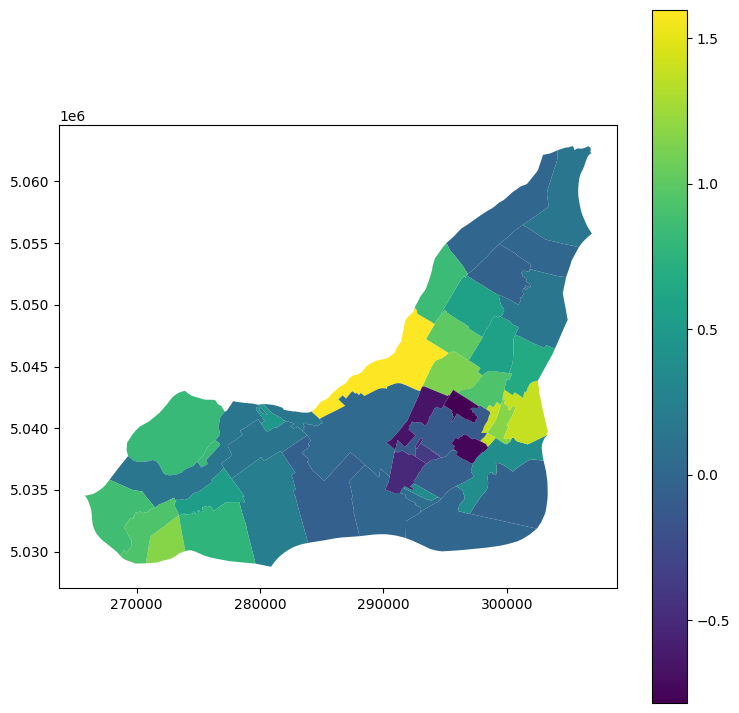

In [38]:
li = esda.moran.Moran_Local(data.NACCIDENTS, w_rook)
data['MORAN'] = li.Is
f, ax = plt.subplots(1, figsize=(9, 9))
data.plot(column='MORAN', legend = True, ax=ax)
li.q
# (if permutations>0) values indicate quandrant location 1 HH, 2 LH, 3 LL, 4 HL

In [39]:
from matplotlib import colors
sig = li.p_sim < 0.05
hotspots = sig * li.q==1
coldspots = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

,RA,SM13,SM13_nom,NACCIDENTS,geometry,DENSITE_ACCIDENTS,NACCIDENTS_LAG,MORAN
16,1.0,101.0,Montreal : Centre-ville,942.0,"POLYGON ((299612.158 5038871.392, 299554.850 5...",0.000262,1069.000000,1.160084
18,1.0,102.0,Montreal : Centre-ville peripherique,1380.0,"MULTIPOLYGON (((299781.635 5043017.554, 299805...",0.000096,843.000000,1.390788
22,2.0,106.0,Montreal : Plateau Mont-Royal,975.0,"POLYGON ((297843.476 5044019.433, 297940.649 5...",0.000133,928.333333,0.929684
23,2.0,109.0,Montreal : Saint-Michel,843.0,"POLYGON ((294059.876 5048264.253, 294099.050 5...",0.000087,1139.800000,1.001664
24,2.0,108.0,Montreal : Ahuntsic,1458.0,"POLYGON ((291568.009 5047668.719, 291600.494 5...",0.000053,859.833333,1.596580
25,2.0,111.0,Montreal : Sud-Est,805.0,"POLYGON ((300491.251 5045340.038, 300499.176 5...",0.000073,981.750000,0.657497
26,2.0,110.0,Montreal : Rosemont,772.0,"POLYGON ((298636.049 5048423.473, 298644.573 5...",0.000065,973.333333,0.570343


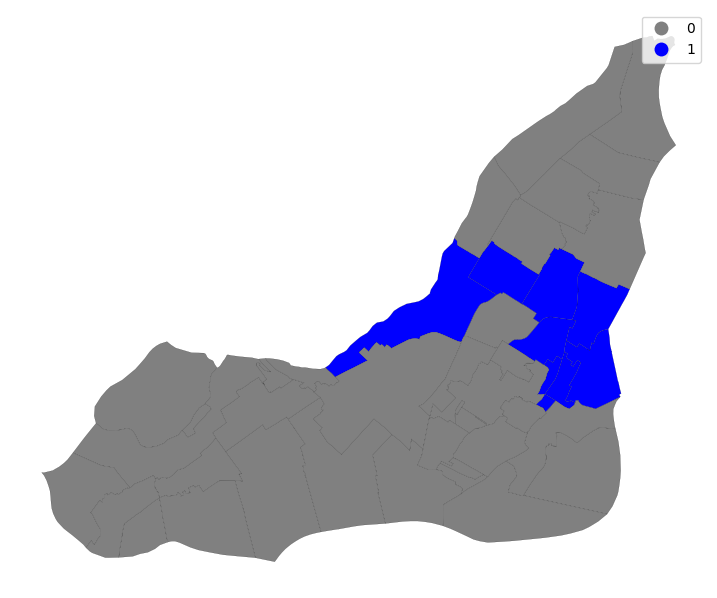

In [40]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
data[hotspots]

,RA,SM13,SM13_nom,NACCIDENTS,geometry,DENSITE_ACCIDENTS,NACCIDENTS_LAG,MORAN
10,4.0,137.0,Kirkland,167.0,"POLYGON ((277273.784 5033997.744, 277012.702 5...",0.000017,225.20,0.529215
12,4.0,139.0,Baie-D'Urfe,29.0,"POLYGON ((273723.820 5031277.314, 273837.497 5...",0.000004,53.00,1.162547
15,4.0,140.0,Sainte-Anne-de-Bellevue,46.0,"POLYGON ((269440.794 5030250.700, 269448.728 5...",0.000004,133.75,0.928955


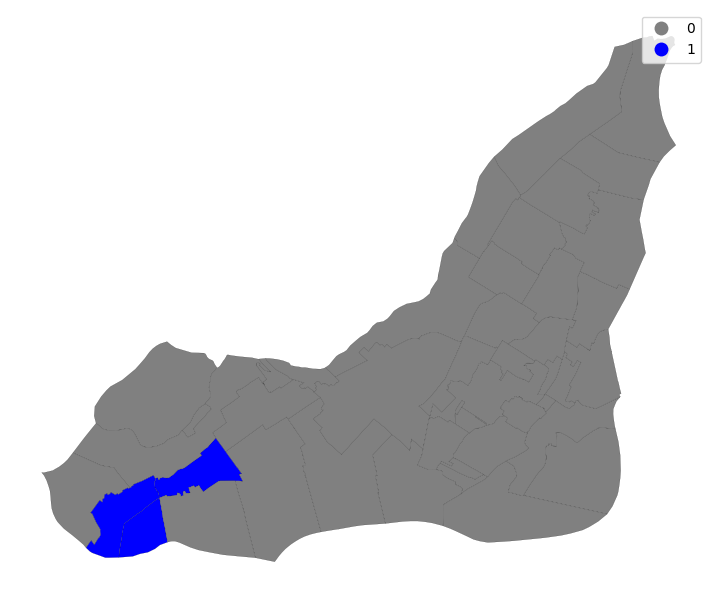

In [41]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
data[coldspots]

<Axes: xlabel='NACCIDENTS', ylabel='Density'>

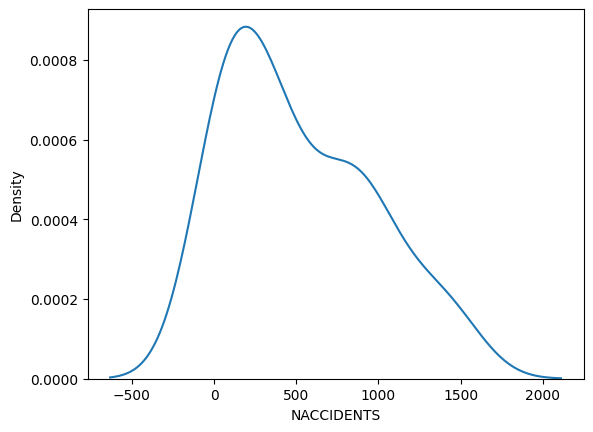

In [42]:
sns.kdeplot(data.NACCIDENTS)

# Segmentation spatiale

In [43]:
import sklearn.cluster as skc

<Axes: >

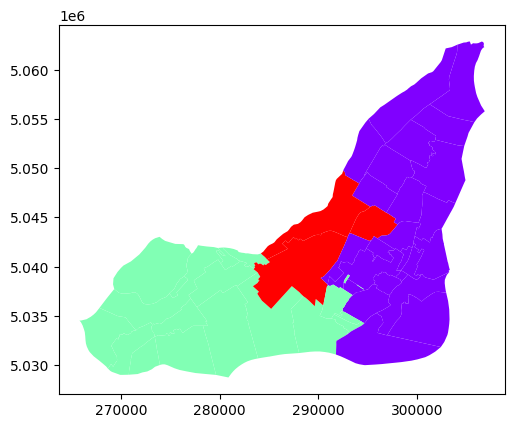

In [44]:
clusters = skc.AgglomerativeClustering(n_clusters=3,connectivity=w_rook.sparse).fit(data[['NACCIDENTS']])
data.assign(labels=clusters.labels_).plot('labels', cmap='rainbow')

<Axes: >

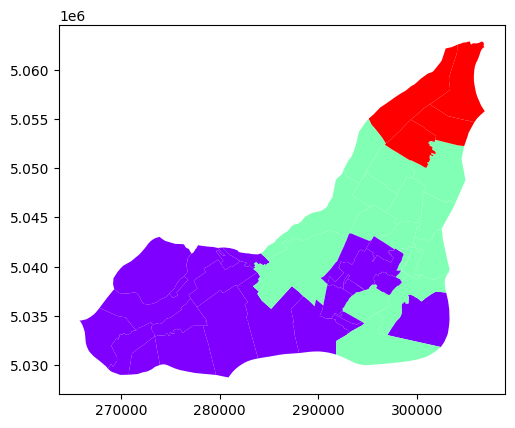

In [45]:
clusters = skc.AgglomerativeClustering(n_clusters=3,connectivity=w_knn.sparse).fit(data[['NACCIDENTS']])
data.assign(labels=clusters.labels_).plot('labels', cmap='rainbow')

<Axes: >

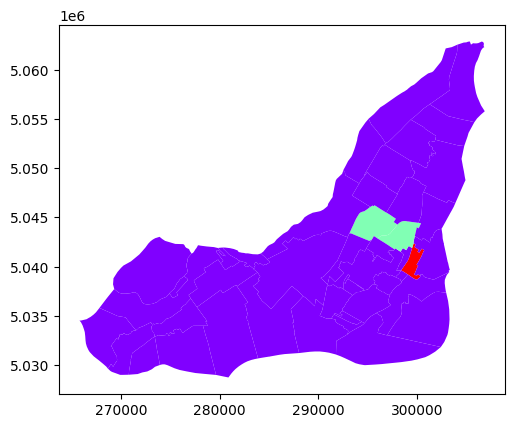

In [46]:
clusters = skc.AgglomerativeClustering(n_clusters=3,connectivity=w_rook.sparse).fit(data[['DENSITE_ACCIDENTS']])
data.assign(labels=clusters.labels_).plot('labels', cmap='rainbow')

< 9. [Fouille de données](09-fouille-donnees.ipynb) | [Contents](index.ipynb) |